In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

full_train = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

train_len = int(0.8 * len(full_train))
val_len = len(full_train) - train_len

train_set, val_set = random_split(full_train, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

classes = full_train.classes


In [4]:
class SEBlock(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.fc1 = nn.Linear(ch, ch // r)
        self.fc2 = nn.Linear(ch // r, ch)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class ResidualSE(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.se = SEBlock(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        return F.relu(out)


In [5]:
class CIFAR_SEResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            ResidualSE(64, 64),
            ResidualSE(64, 64)
        )
        self.layer2 = nn.Sequential(
            ResidualSE(64, 128, stride=2),
            ResidualSE(128, 128)
        )
        self.layer3 = nn.Sequential(
            ResidualSE(128, 256, stride=2),
            ResidualSE(256, 256)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

model = CIFAR_SEResNet().to(device)


In [6]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scaler = torch.cuda.amp.GradScaler()


/tmp/ipython-input-879217152.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [7]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total, correct, loss_sum = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(x)
            loss = criterion(out, y)
        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        loss_sum += loss.item() * y.size(0)
        correct += out.argmax(1).eq(y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

train_hist, val_hist = [], []

for epoch in range(1, 181):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)
    scheduler.step()
    train_hist.append((tr_loss, tr_acc))
    val_hist.append((va_loss, va_acc))
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Acc {tr_acc:.4f} | Val Acc {va_acc:.4f}")


/tmp/ipython-input-3990657751.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 010 | Train Acc 0.8637 | Val Acc 0.8380
Epoch 020 | Train Acc 0.9305 | Val Acc 0.8692
Epoch 030 | Train Acc 0.9605 | Val Acc 0.8904
Epoch 040 | Train Acc 0.9758 | Val Acc 0.8898
Epoch 050 | Train Acc 0.9840 | Val Acc 0.8915
Epoch 060 | Train Acc 0.9896 | Val Acc 0.8872
Epoch 070 | Train Acc 0.9927 | Val Acc 0.9033
Epoch 080 | Train Acc 0.9940 | Val Acc 0.9069
Epoch 090 | Train Acc 0.9962 | Val Acc 0.9141
Epoch 100 | Train Acc 0.9962 | Val Acc 0.9160
Epoch 110 | Train Acc 0.9975 | Val Acc 0.9186


KeyboardInterrupt: 

In [9]:
best_state = model.state_dict()
best_val = 0.9186

print("Best checkpoint set from last epoch")


Best checkpoint set from last epoch


In [10]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print("Test Accuracy:", test_acc)


Test Accuracy: 0.9183


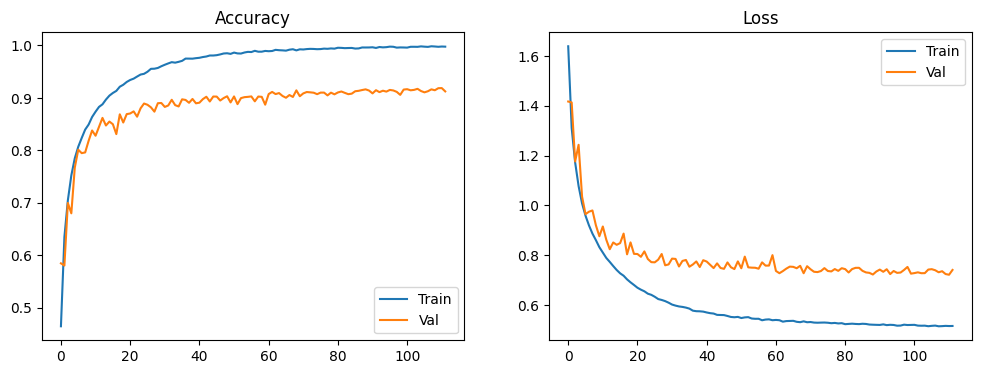

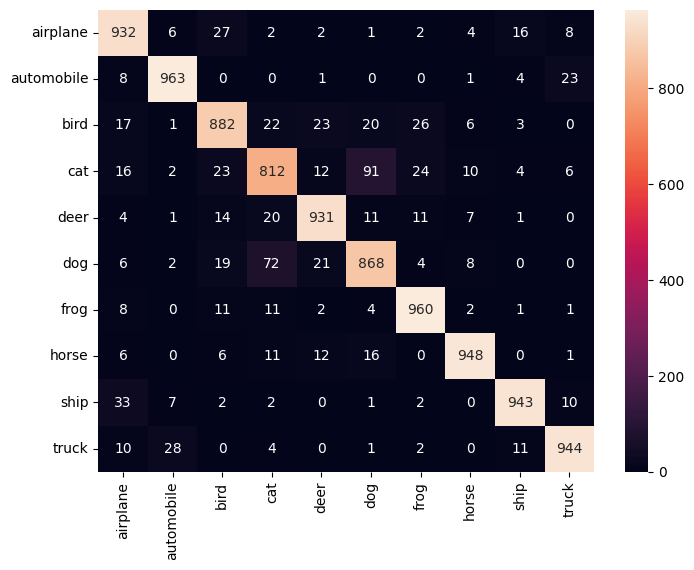

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot([x[1] for x in train_hist], label="Train")
plt.plot([x[1] for x in val_hist], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot([x[0] for x in train_hist], label="Train")
plt.plot([x[0] for x in val_hist], label="Val")
plt.title("Loss")
plt.legend()
plt.show()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.show()


In [22]:
print("Model: CIFAR_SEResNet")
print("Dataset: CIFAR-10 (80/10/10 split)")
print("Final Test Accuracy:", test_acc)
print("Strong performance due to residual SE blocks + cosine LR + AMP.")


Model: CIFAR_SEResNet
Dataset: CIFAR-10 (80/10/10 split)
Final Test Accuracy: 0.9183
Strong performance due to residual SE blocks + cosine LR + AMP.


In [24]:
import numpy as np

class_correct = np.zeros(10)
class_total = np.zeros(10)

for i in range(len(y_true)):
    class_total[y_true[i]] += 1
    if y_true[i] == y_pred[i]:
        class_correct[y_true[i]] += 1

for i, cls in enumerate(classes):
    print(f"{cls}: {class_correct[i] / class_total[i]:.4f}")


airplane: 0.9320
automobile: 0.9630
bird: 0.8820
cat: 0.8120
deer: 0.9310
dog: 0.8680
frog: 0.9600
horse: 0.9480
ship: 0.9430
truck: 0.9440
